<a href="https://www.kaggle.com/code/mahfud08/ta-cv-wildfire-detection?scriptVersionId=159122211" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import cv2
import numpy as np
import pandas as pd
import os

In [2]:
# defining dir variables 
root_dir = '/kaggle/input/wildfire-detection-image-data/forest_fire'
train_dir = root_dir + '/Training and Validation/'
test_dir = root_dir + '/Testing/'

In [3]:
# mendefinisikan fungsi untuk mengubah gambar menjadi array
def preprocessing(img_path):
    # membaca gambar dari path
    img = cv2.imread(img_path)
    # mengubah ukuran gambar menjadi 224 x 224
    img = cv2.resize(img, (224, 224))

    return img

In [4]:
# mendefinisikan fungsi untuk load gambar dari sebuah folder
def load_images_from_folder(folder):
    # membuat list kosong untuk menyimpan gambar dan label
    images = []
    labels = []
    # mengiterasi setiap subfolder dalam folder
    for subfolder in os.listdir(folder):
        # mendapatkan label dari nama subfolder
        label = subfolder
        # mengiterasi setiap file dalam subfolder
        for filename in os.listdir(folder + subfolder):
            # mendapatkan path lengkap dari file
            img_path = folder  + subfolder + '/' + filename
            # mengubah gambar menjadi array
            img = preprocessing(img_path)
            # menambahkan gambar dan label ke list
            images.append(img)
            labels.append(label)
    # mengubah list menjadi array
    images = np.array(images)
    labels = np.array(labels)

    list_label=np.unique(labels) #mendapatkan label unik
    label_dict = {label: idx for idx, label in enumerate(list_label)} #masukkan dalam list
    label_numerik = [label_dict[s] for s in labels] #ubah kedalam numerik
    label_numerik_array = np.array(label_numerik)
    
    # mengembalikan gambar dan label
    return images, label_numerik_array, label_dict

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'fire': 0, 'nofire': 1}


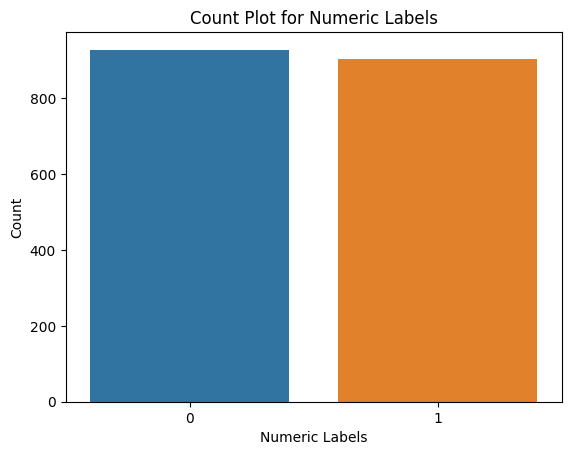

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train, label_numerik_array_train, label_dict = load_images_from_folder(train_dir)
X_test, label_numerik_array_test, label_dict = load_images_from_folder(test_dir)
print(label_dict)

# Visualisasikan dalam jumlah dalam plot
sns.countplot(x=label_numerik_array_train)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()

# simpan dalam file npy untuk labeling
np.save('/kaggle/working/label_knn.npy', label_dict)

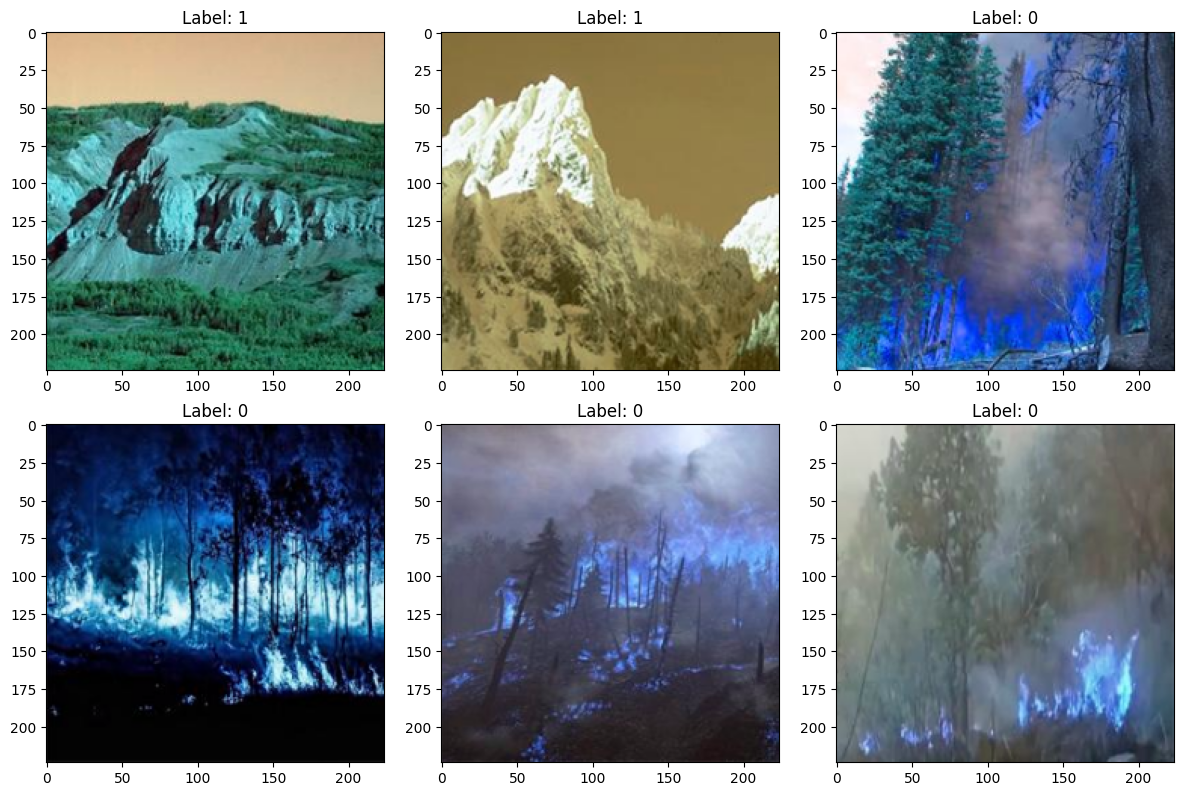

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 6 indices from the data
random_indices = np.random.choice(len(X_train), 6, replace=False)

# Plot the images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])
    plt.title("Label: " + str(label_numerik_array_train[idx]))
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split #library untuk train test split

# First, split data into train and temp sets (70% train, 30% temp)
X_train, X_val, y_train, y_val = train_test_split(X_train, label_numerik_array_train, test_size=0.1, random_state=42, stratify=label_numerik_array_train)
X_test, y_test = (X_test,label_numerik_array_test)

In [8]:
# Print the sizes of each set
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (1648, 224, 224, 3) (1648,)
Validation set: (184, 224, 224, 3) (184,)
Test set: (68, 224, 224, 3) (68,)


In [9]:
# import library mobilenet dari keras
import tensorflow as tf
from keras.applications import MobileNetV2 as Mdl
from tensorflow.keras.models import Model

# mendefinisikan fungsi untuk membuat model mobilenet
def mobilenet():
    base_model = Mdl(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=2) #model TF IMAGENET

    for layer in base_model.layers: #FREEZ ALL LAYER karena tfl
        layer.trainable = False

    model= tf.keras.Sequential()
    model.add(base_model) #tambahkan beberapa layer
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(2, activation="softmax")(x) #softmax untuk multiclass
    model = Model(inputs=model.input, outputs=predictions)
    # mengembalikan model yang dibuat
    return model

# membuat model mobilenet dengan memanggil fungsi yang telah dibuat
model = mobilenet()

# menampilkan ringkasan model
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input  [(None, 224, 224, 3)]     0         
  (InputLayer)                                                   
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                

In [10]:
from keras import optimizers, losses, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Enable MirroredStrategy for multiple GPU training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = mobilenet()
    # meng-compile model dengan menggunakan optimizer RMSprop
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',  metrics=['accuracy']) #compile model
    callbacks = [ModelCheckpoint(f"/kaggle/working/best_weight.h5", monitor='val_loss', save_best_only=True)] #simpan model
    history = model.fit(X_train, y_train,validation_data=(X_val,y_val), batch_size=32, epochs=30, verbose=0, callbacks=callbacks, workers=-1) #train model

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


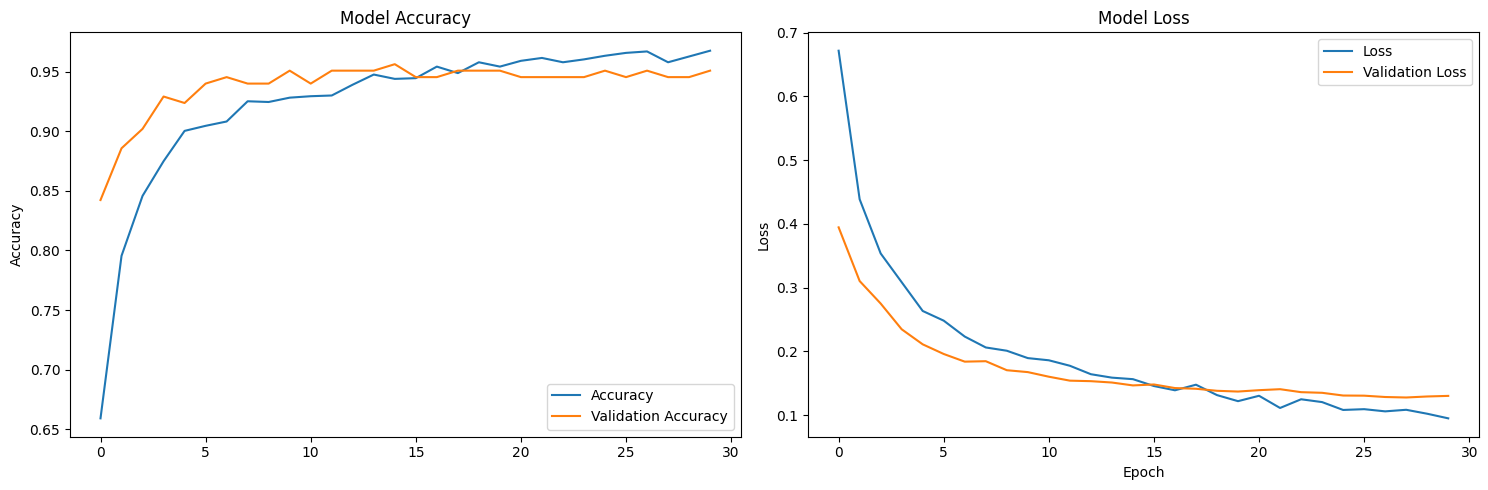

In [11]:
import matplotlib.pyplot as plt

# Plot grafik kiri
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

# Plot grafik kanan
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss", "Validation Loss"])
plt.tight_layout()
# Simpan gambar ke file
plt.show()

In [12]:
y_pred = model.predict(X_test, batch_size=1) #test model

68/68 [==============================] - 3s 7ms/step


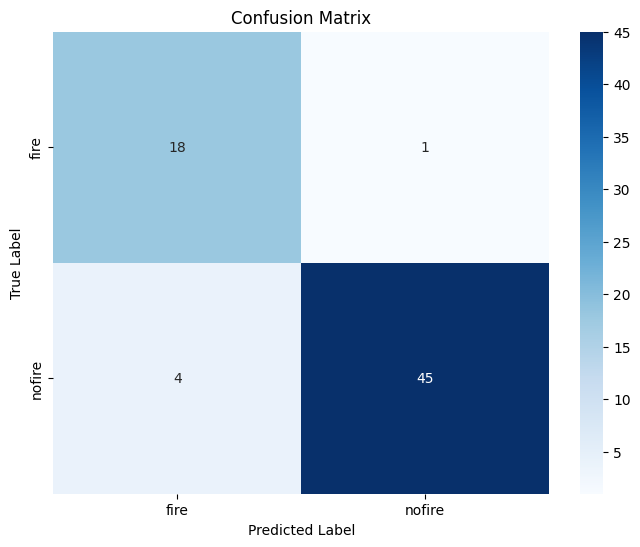

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
multiclass_predictions = np.argmax(y_pred, axis=1) #proses probabilitas
cm = confusion_matrix(multiclass_predictions, y_test)#plot cm
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict, yticklabels=label_dict)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [14]:
report = classification_report(multiclass_predictions, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.98      0.92      0.95        49

    accuracy                           0.93        68
   macro avg       0.90      0.93      0.91        68
weighted avg       0.93      0.93      0.93        68



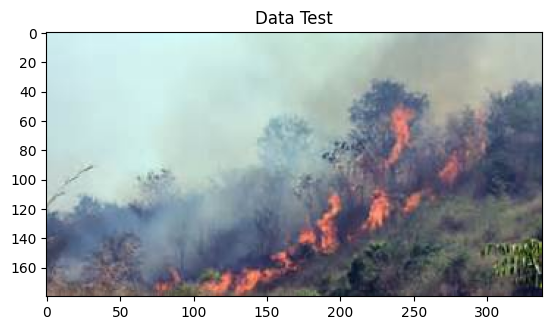

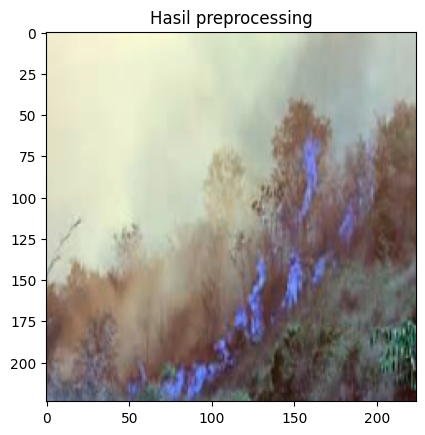

ukuran gambar test (1, 224, 224, 3)
1/1 [==============================] - 0s 120ms/step
nilai probabilitas [[0.9958305  0.00416956]]
fire = 99.58304762840271%
nofire = 0.41695614345371723%
prediksinya: ['fire']
The predicted image is : [0] -> ['fire']


In [15]:
import matplotlib.pyplot as plt
import cv2
import os
import os.path
import numpy as np

img_path= '/kaggle/input/datatest/dataluar/th (1).jpeg'
img=cv2.imread(img_path)
plt.figure()
plt.title("Data Test")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#pastikan langkah preprocessing yang dilakukan sama dengan data train
# mengubah ukuran gambar menjadi 224 x 224
img_resize = cv2.resize(img, (224, 224))
#tampilkan hasil
plt.figure()
plt.title("Hasil preprocessing")
plt.imshow(img_resize)
plt.show()

test = img_resize.reshape((1, 224, 224, 3))

print(f"ukuran gambar test {test.shape}") #sama dengan input shape

# Mengecek hasil klasifikasi pada salah satu dataset
probability=model.predict(test)
print(f"nilai probabilitas {probability}") #tampilkan nilai probabilitas tiap kelas



for ind,val in enumerate(label_dict): #mendapatkan nama kelas dan hasil akurasi
    print(f'{val} = {probability[0][ind]*100}%')


hasil = np.argmax(probability, axis=-1) #mendapatkan kelas dari probabilitas terbaik
key_found = [key for key, value in label_dict.items() if value == hasil] #dapatkan namanya
print(f"prediksinya: {key_found}")
print(f"The predicted image is : {str(hasil)} -> {key_found}")